Importing Libraries

In [19]:
import os
import cv2
import numpy as np
import torch
import webcolors
import torchvision
from tqdm import tqdm
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.transforms.functional import resize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

DEEPLABV3 MODEL - COLOUR EXTRACTION

In [30]:
COLOURS = {
    # --- Neutrals & Shadows (The 'Link' for backgrounds and lighting) ---
    "Pure White": [255, 128, 128],
    "Off-White/Cream": [245, 124, 140],
    "Light Gray": [216, 128, 128],
    "Medium Gray": [137, 128, 128],
    "Shadow_Light": [177, 128, 128],  # Found in your logs near 138-170
    "Shadow_Dark": [69, 128, 128],    # Found in your logs near 50-70
    "Charcoal": [72, 125, 120],
    "Black": [0, 128, 128],

    # --- Skin Tones (Crucial to prevent mislabeling the person as clothes) ---
    "Skin_Fair": [228, 134, 156],
    "Skin_Tan": [191, 133, 152],
    "Skin_Deep": [106, 147, 165],
    "Skin_Dark": [52, 133, 135],

    # --- Blues ---
    "Navy Blue": [33, 175, 63],
    "Royal Blue": [122, 154, 63],
    "Sky Blue": [202, 113, 107],
    "Light Blue": [214, 117, 117],
    "Teal": [123, 99, 119],
    "Turquoise": [207, 84, 124],

    # --- Reds & Pinks ---
    "Red": [136, 208, 195],
    "Burgundy/Maroon": [65, 176, 166],
    "Crimson": [120, 199, 162],
    "Hot Pink": [167, 192, 117],
    "Dusty Pink": [204, 141, 119],
    "Light Pink": [207, 156, 133],
    "Coral": [172, 173, 175],
    "Peach": [228, 136, 149],

    # --- Greens ---
    "Emerald Green": [185, 77, 158],
    "Forest Green": [129, 79, 173],
    "Olive Green": [132, 115, 185],
    "Mint Green": [234, 78, 168],
    "Light Green": [221, 82, 165],
    "Lime/Neon Green": [185, 61, 189],

    # --- Yellows & Oranges ---
    "Yellow": [248, 106, 223],
    "Light Yellow": [253, 123, 143],
    "Mustard Yellow": [225, 126, 195],
    "Gold": [222, 126, 215],
    "Orange": [191, 152, 207],
    "Terracotta/Rust": [155, 170, 161],

    # --- Purples ---
    "Purple": [76, 187, 91],
    "Lavender": [234, 132, 118],
    "Plum": [104, 168, 106],
    "Light Purple": [174, 148, 100],

    # --- Browns & Earth Tones ---
    "Chocolate Brown": [143, 165, 185],
    "Tan/Sand": [191, 133, 152],
    "Beige/Khaki": [245, 124, 140],
    "Coffee": [92, 139, 147]
}


def get_colour_name(lab_pixel):
    distances = {}
    for colour, lab_value in COLOURS.items():
        distance = np.linalg.norm(np.array(lab_pixel) - np.array(lab_value))
        distances[colour] = distance
    return min(distances, key=distances.get)

def name_to_lab(colour_name):
    if colour_name not in COLOURS:
        print(f"Warning: '{colour_name}' not found in COLOURS dictionary. \nDefaulting to 'UNKNOWN COLOUR!'")
    lab_val = np.uint8([[COLOURS.get(colour_name)]])
    rgb_val = cv2.cvtColor(lab_val, cv2.COLOR_LAB2RGB)[0][0]
    return rgb_val / 255.0

In [ ]:
def process_all_colours(main_folder_path, output_csv_path):
    all_brand_data = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')
    model2.to(device)
    model2.eval()

    preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    for brand_name in os.listdir(main_folder_path):
        brand_folder = os.path.join(main_folder_path, brand_name)
        
        if not os.path.isdir(brand_folder):
            continue

        print(f"Processing brand: {brand_name}")
        good_img = [ f for f in os.listdir(brand_folder) if f.lower().endswith(('.jpg','.jpeg', '.png'))]


        for img_name in good_img:
            img_path = os.path.join(brand_folder, img_name)

            try:
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image).unsqueeze(0).to(device)
                # input_tensor = preprocess(input_image)
                # processed_img = torch.stack(input_tensor)

                with torch.no_grad():
                    outputs = model2(input_tensor)['out'][0]
                    
                #mask = torch.argmax(outputs, dim=0).cpu().numpy()
                mask = torch.argmax(outputs, dim=1)
                print(f"Segmentation completed for {img_name}.\n")
                
                garment_masks = (mask == 15) #15 is for a person in the model
                
                mask_img = input_image.resize((520, 520))
                # mask_img = resize(input_image, mask.shape[-2:])

                img_np = np.array(mask_img)
                # mask_np = mask.cpu().numpy()
                # masked_img = img_np * mask_np[:, :, None]  # Apply mask to the image

                img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
                # img_lab = cv2.cvtColor(masked_img.astype(np.uint8), cv2.COLOR_RGB2LAB)                        
                    
                pixels = img_lab[garment_masks]

                if len(pixels) > 0:
                    #samples = pixels_flat[::10]

                    n = 5
                    kmeans = KMeans(n_clusters=n, random_state=42)
                    kmeans.fit(pixels)
                    
                    EXCLUDE_LIST = ["Skin_Fair", "Skin_Tan", "Skin_Deep", "Skin_Dark", "Shadow_Light", "Shadow_Dark", "Medium Gray"]    
                    names = []
                    for centroid in kmeans.cluster_centers_:
                        # Use the function you already have in your script
                        colour_name = get_colour_name(centroid)
                        
                        if colour_name not in EXCLUDE_LIST:
                            # We calculate the distance one more time to see if it's too far
                            best_lab = np.array(COLOURS[colour_name])
                            dist = np.linalg.norm(centroid - best_lab)
                            print(f"Centroid: {centroid} -> Identified as: {colour_name} (Distance: {dist:.2f})")


                            # Change your threshold logic to this:
                            if dist < 40: 
                                # This is a high-confidence match
                                names.append(colour_name)
                            elif dist < 45:
                                # This is a 'maybe' - label it as generic
                                names.append(f"Possible_{colour_name}")
                            else:
                                # This is a complete guess - label as Unknown
                                names.append("Unknown/Other")
                                            
                    unique_names = list(set(names))
                    if "Black" in unique_names and len(unique_names) > 1:
                        unique_names.remove("Black")
                
                    all_brand_data.append({
                        "brand": brand_name,
                        "image": img_name,
                        "colours": ", ".join(unique_names)})
                
                # # DEBUG: Check centroids for Ajabeng
                # kmeans = KMeans(n_clusters=3, random_state=42).fit(pixels)
                # for i, center in enumerate(kmeans.cluster_centers_):
                #     name = get_colour_name(center)
                #     dist = np.linalg.norm(center - np.array(COLOURS.get(name, [0,0,0])))
                #     print(f"Centroid {i}: {center} -> Identified as: {name} (Distance: {dist:.2f})")   
                
            except Exception as e:
                print(f"skipping {img_name} due to error: {e}")
        print(f"Segmentation completed for {brand_name}.\n")

    df = pd.DataFrame(all_brand_data)
    df.to_csv(output_csv_path, index=False)
    print("Colour analysis completed and saved to CSV.")

    return all_brand_data

In [34]:
main_folder_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\data\runway'
output_csv_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\runway_colours.csv'

extracted_colours = process_all_colours(main_folder_path, output_csv_path)

Processing brand: adage_studio_project_x_unrefyned
skipping last_three_10.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_11.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_12.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_13.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_14.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_15.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_4.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor
skipping last_three_5.jpg due to error: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

KeyboardInterrupt: 

OVERALL FREQUENCY OF COLOURS

In [23]:
colour_present = []

for entry in extracted_colours:
    # split by comma because we saved them as a string in the CSV format
    names = entry['colours'].split(", ")
    colour_present.extend(names)

# 2. Count and Sort
colour_count = Counter(colour_present)
sorted_colours = dict(sorted(colour_count.items(), key=lambda item: item[1], reverse=True))

# 3. Prepare for Plotting
names = list(sorted_colours.keys())
counts = list(sorted_colours.values())
total_colours = sum(counts)
percentages = [(count / total_colours) * 100 for count in counts]

# Print the top 5 colors for a quick check
print("Top 5 Colours across the entire runway:")
for i in range(5):
    print(f"{names[i]}: {counts[i]} garments ({percentages[i]:.2f}%)")

Top 5 Colours across the entire runway:
Coffee: 659 garments (27.99%)
Light Gray: 326 garments (13.85%)
Lavender: 216 garments (9.18%)
Terracotta/Rust: 173 garments (7.35%)
Dusty Pink: 165 garments (7.01%)


VISUALIZATION

In [26]:
df1 = pd.read_csv(output_csv_path)
all_colour_names =[]
for val in df1['colours'].dropna():
    names = val.split(", ")
    all_colour_names.extend(names)
    

plot_colours = [name_to_lab(colour) for colour in names]

WHOLE RUNWAY STATS

Visualization report saved to: C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_frequency.png


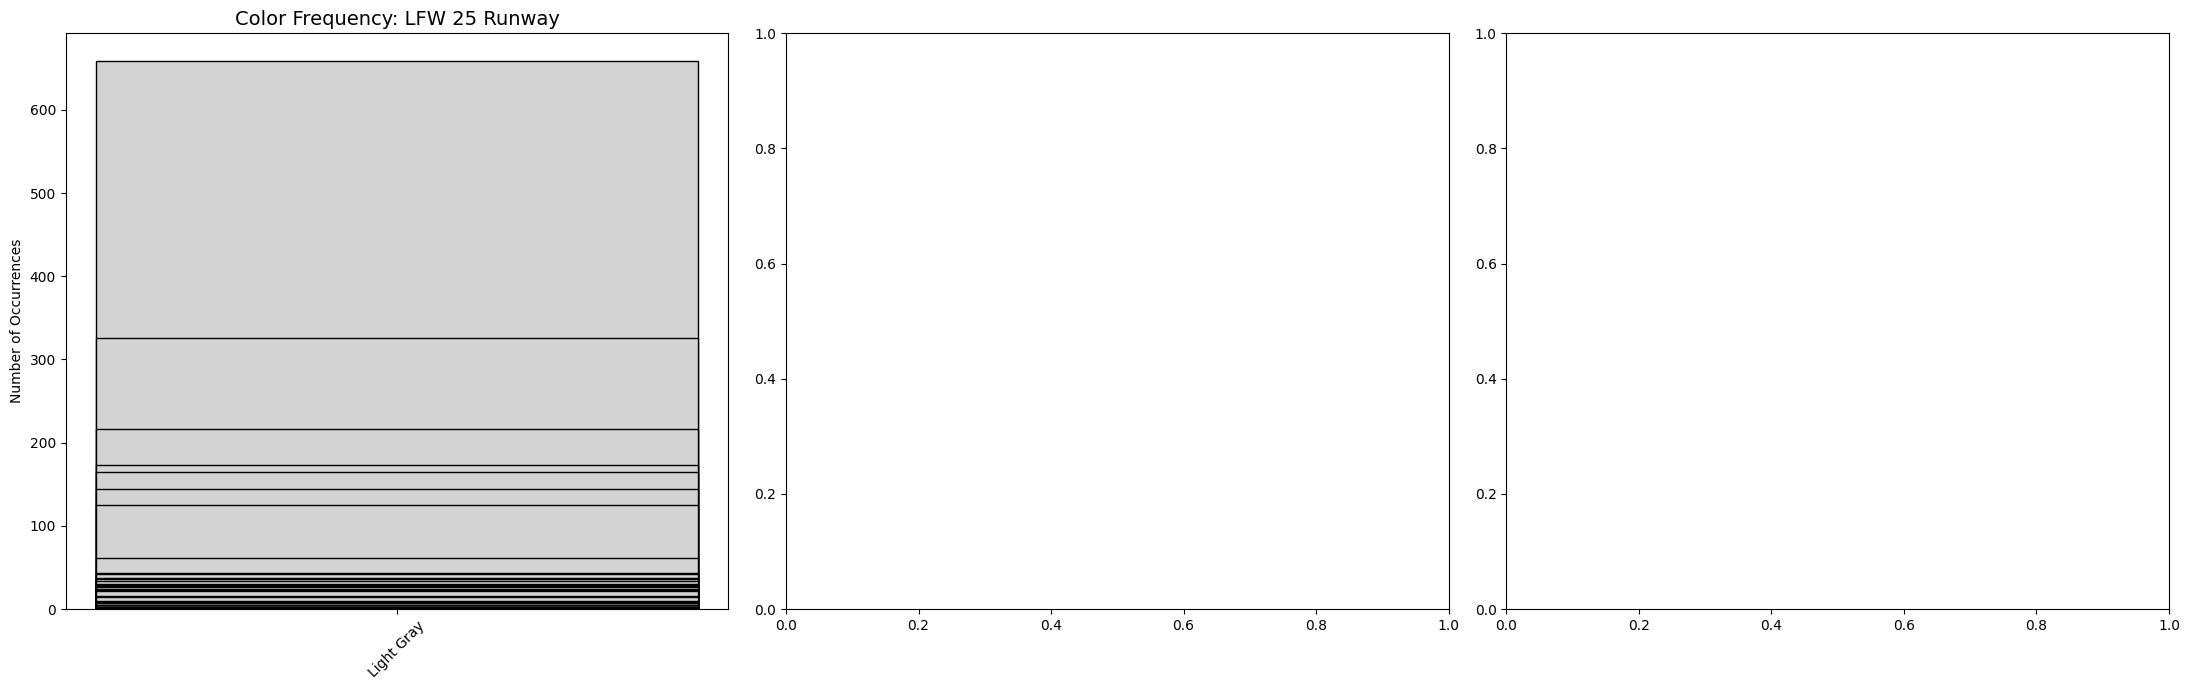

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
# A. Bar Chart: Frequency 
axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
axes[0].set_title('Color Frequency: LFW 25 Runway', fontsize=14)
axes[0].set_ylabel('Number of Occurrences')
axes[0].tick_params(axis='x', rotation=45)

plt.tight_layout()
freq_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_frequency.png'
plt.savefig(freq_img_path, dpi=300)
print(f"Visualization report saved to: {freq_img_path}")


In [28]:
# B. Percentage Chart: Distribution
axes[1].pie(percentages, labels=names, autopct='%1.1f%%', 
            colors=plot_colours, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Overall Color Distribution (%)', fontsize=14)

plt.tight_layout()
dist_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_distribution.png'
plt.savefig(dist_img_path, dpi=300)
print(f"Visualization report saved to: {dist_img_path}")
plt.show()

ValueError: 'labels' must be of length 'x', not 1

In [ ]:
# C. Color Palette: The "Runway Palette"
# We create a simple strip showing the dominant colors in order
palette_img = np.zeros((100, 500, 3))
start = 0
for i, perc in enumerate(percentages):
    end = start + int((perc / 100) * 500)
    palette_img[:, start:end] = plot_colours[i]
    start = end

axes[2].imshow(palette_img)
axes[2].axis('off')
axes[2].set_title('Overall LFW 25 Runway Palette', fontsize=14)

plt.tight_layout()
palette_img_path = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats\overall_colour_palette.png'
plt.savefig(palette_img_path, dpi=300)
print(f"Visualization report saved to: {palette_img_path}")
plt.show()

BRAND SPECIFIC STATS

In [29]:
output_dir = r'C:\Users\User\OneDrive\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\outputs\stats'
unique_brands = df1['brand'].unique()

for brand in unique_brands:
    brand_data = df1[df1['brand'] == brand]
    brand_colours = []
    
    for val in brand_data['colours'].dropna():
        names = val.split(", ")
        brand_colours.extend(names)
    
    if not brand_colours: 
        continue
    
    brand_colour_count = Counter(brand_colours)
    sorted_brand_colours = dict(sorted(brand_colour_count.items(), key=lambda item: item[1], reverse=True))
    
    names = list(sorted_brand_colours.keys())
    counts = list(sorted_brand_colours.values())
    total_brand_colours = sum(counts)
    percentages = [(count / total_brand_colours) * 100 for count in counts]
    plot_colours = [name_to_lab(colour) for colour in names]

    print(f"\n Processing Brand: {brand}")
    
    # Print the top 5 colors for a quick check
    print(f"\nTop 5 Colours across {brand} runway:")
    for i in range(5):
        print(f"{names[i]} is found in {percentages[i]:.2f}% of {brand}'s collection.")
    
    # 4. Create the Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f"Colour Analysis: {brand.upper()}", fontsize=20, fontweight='bold')

    # A. Bar Chart
    axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
    axes[0].set_title('Frequency of Colours')
    axes[0].tick_params(axis='x', rotation=45)

    # B. Pie Chart
    axes[1].pie(percentages, labels=names, autopct='%1.1f%%', colors=plot_colours, 
                startangle=140, wedgeprops={'edgecolor': 'black'})
    axes[1].set_title('Distribution (%)')

    # C. Color Palette: The "Runway Palette"
    # We create a simple strip showing the dominant colors in order
    palette_img = np.zeros((100, 500, 3))
    start = 0
    for i, perc in enumerate(percentages):
        end = start + int((perc / 100) * 500)
        if i == len(percentages) - 1:  # Ensure the last color fills any remaining space
            end = 500

        palette_img[:, start:end] = plot_colours[i]
        start = end

    axes[2].imshow(palette_img)
    axes[2].axis('off')
    axes[2].set_title('Runway Palette', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 5. Save the report
    brand_filename = f"{brand.replace(' ', '_')}_report.png"
    plt.savefig(os.path.join(output_dir, brand_filename), dpi=200)
    plt.close() # Close plot to save memory during loop

print(f"COMPLETED! ALL BRAND STATS ARE SAVED IN: {output_dir}")


 Processing Brand: adage_studio_project_x_unrefyned

Top 5 Colours across adage_studio_project_x_unrefyned runway:
Coffee is found in 31.25% of adage_studio_project_x_unrefyned's collection.
Dusty Pink is found in 18.75% of adage_studio_project_x_unrefyned's collection.
Lavender is found in 18.75% of adage_studio_project_x_unrefyned's collection.
Charcoal is found in 12.50% of adage_studio_project_x_unrefyned's collection.
Light Gray is found in 6.25% of adage_studio_project_x_unrefyned's collection.

 Processing Brand: adama_paris

Top 5 Colours across adama_paris runway:
Coffee is found in 47.50% of adama_paris's collection.
Chocolate Brown is found in 22.50% of adama_paris's collection.
Orange is found in 10.00% of adama_paris's collection.
Terracotta/Rust is found in 7.50% of adama_paris's collection.
Coral is found in 7.50% of adama_paris's collection.

 Processing Brand: ajabeng

Top 5 Colours across ajabeng runway:
Coffee is found in 47.83% of ajabeng's collection.
Lavender is 

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

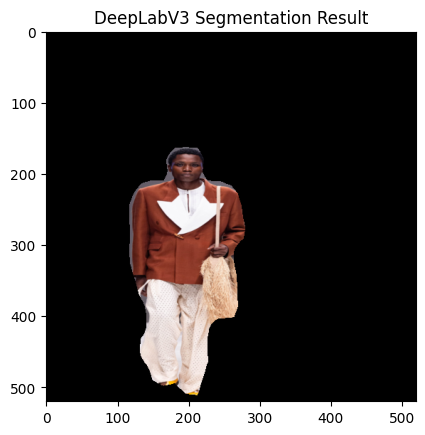

: 

In [ ]:
# Show the result of DeepLabV3 for the first image
plt.imshow(garment_img[10])
plt.title("DeepLabV3 Segmentation Result")
plt.show()

In [ ]:
def visualize_segmentation(image_path):
    # Load original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the mask from your existing model
    mask = get_person_mask(image)
    
    # Apply the mask to show isolated pixels
    person_only = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask (White = Detected)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(person_only)
    plt.title("Pixels used for Colour Analysis")
    plt.axis('off')
    
    plt.show()

# Test it on one of your questionable images
visualize_segmentation("path/to/your/image/boyedoe_6.jpg")